In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from matplotlib import pyplot as plt

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler,OneHotEncoder

from imblearn.metrics import classification_report_imbalanced
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier


# Read the CSV and Remove Columns Deemed Low Importance

In [4]:
# Loading data USING CSV that contains cleanded values for MaritalStatus and Gender and dropped OwnCar
file_path = Path("../Resources/TravelCleanedSkiLearnImputer.csv")
df = pd.read_csv(file_path)
df.head()

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,200000,1,41.000000,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0
1,200001,0,49.000000,Company Invited,1,14.0,Salaried,Male,3,4.0,Deluxe,4.0,Single,2.0,0,3,1,2.0,Manager,20130.0
2,200002,1,37.000000,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Basic,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0
3,200003,0,33.000000,Company Invited,1,9.0,Salaried,Female,2,3.0,Basic,3.0,Single,2.0,1,5,1,1.0,Executive,17909.0
4,200004,0,37.622265,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Single,1.0,0,5,1,0.0,Executive,18468.0


In [5]:
#Drop columns not needed
features_df = df.copy()
features_df = df.drop(["ProdTaken","CustomerID","Designation","Occupation"], axis=1)
features_df

,Age,TypeofContact,CityTier,DurationOfPitch,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,MonthlyIncome
0,41.000000,Self Enquiry,3,6.0,Female,3,3.0,Deluxe,3.0,Single,1.0,1,2,1,0.0,20993.0
1,49.000000,Company Invited,1,14.0,Male,3,4.0,Deluxe,4.0,Single,2.0,0,3,1,2.0,20130.0
2,37.000000,Self Enquiry,1,8.0,Male,3,4.0,Basic,3.0,Single,7.0,1,3,0,0.0,17090.0
3,33.000000,Company Invited,1,9.0,Female,2,3.0,Basic,3.0,Single,2.0,1,5,1,1.0,17909.0
4,37.622265,Self Enquiry,1,8.0,Male,2,3.0,Basic,4.0,Single,1.0,0,5,1,0.0,18468.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4883,49.000000,Self Enquiry,3,9.0,Male,3,5.0,Deluxe,4.0,Single,2.0,1,1,1,1.0,26576.0
4884,28.000000,Company Invited,1,31.0,Male,4,5.0,Basic,3.0,Single,3.0,1,3,1,2.0,21212.0
4885,52.000000,Self Enquiry,3,17.0,Female,4,4.0,Standard,4.0,Married,7.0,0,1,1,3.0,31820.0
4886,19.000000,Self Enquiry,3,16.0,Male,3,4.0,Basic,3.0,Single,3.0,0,5,0,2.0,20289.0


# Split the Data into Training and Testing

In [6]:
# Generate our categorical variable list
features_df_cat = features_df.dtypes[features_df.dtypes == "object"].index.tolist()

# Check the number of unique values in each column
features_df[features_df_cat].nunique()

TypeofContact     2
Gender            2
ProductPitched    5
MaritalStatus     2
dtype: int64

In [7]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(features_df[features_df_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(features_df_cat)
encode_df.head()

,TypeofContact_Company Invited,TypeofContact_Self Enquiry,Gender_Female,Gender_Male,ProductPitched_Basic,ProductPitched_Deluxe,ProductPitched_King,ProductPitched_Standard,ProductPitched_Super Deluxe,MaritalStatus_Married,MaritalStatus_Single
0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
# Merge one-hot encoded features and drop the originals
features_df = features_df.merge(encode_df,left_index=True, right_index=True)
features_df = features_df.drop(features_df_cat,1)
features_df.head()

,Age,CityTier,DurationOfPitch,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,...,TypeofContact_Self Enquiry,Gender_Female,Gender_Male,ProductPitched_Basic,ProductPitched_Deluxe,ProductPitched_King,ProductPitched_Standard,ProductPitched_Super Deluxe,MaritalStatus_Married,MaritalStatus_Single
0,41.000000,3,6.0,3,3.0,3.0,1.0,1,2,1,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,49.000000,1,14.0,3,4.0,4.0,2.0,0,3,1,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,37.000000,1,8.0,3,4.0,3.0,7.0,1,3,0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,33.000000,1,9.0,2,3.0,3.0,2.0,1,5,1,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,37.622265,1,8.0,2,3.0,4.0,1.0,0,5,1,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [9]:
# Define the features set.
X = features_df.copy()
X

,Age,CityTier,DurationOfPitch,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,...,TypeofContact_Self Enquiry,Gender_Female,Gender_Male,ProductPitched_Basic,ProductPitched_Deluxe,ProductPitched_King,ProductPitched_Standard,ProductPitched_Super Deluxe,MaritalStatus_Married,MaritalStatus_Single
0,41.000000,3,6.0,3,3.0,3.0,1.0,1,2,1,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,49.000000,1,14.0,3,4.0,4.0,2.0,0,3,1,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,37.000000,1,8.0,3,4.0,3.0,7.0,1,3,0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,33.000000,1,9.0,2,3.0,3.0,2.0,1,5,1,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,37.622265,1,8.0,2,3.0,4.0,1.0,0,5,1,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4883,49.000000,3,9.0,3,5.0,4.0,2.0,1,1,1,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4884,28.000000,1,31.0,4,5.0,3.0,3.0,1,3,1,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4885,52.000000,3,17.0,4,4.0,4.0,7.0,0,1,1,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4886,19.000000,3,16.0,3,4.0,3.0,3.0,0,5,0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [10]:
# Define the target set.
y = df["ProdTaken"]


In [11]:
# Check the balance of our target values
y.value_counts()

0    3968
1     920
Name: ProdTaken, dtype: int64

In [12]:
# Scale and Normalize Data
data_scaled=StandardScaler()

# fit and transfor data
X_scaled=data_scaled.fit_transform(X)
#View first row
X_scaled[:1]

array([[ 0.37128216,  1.46836869, -1.14387064,  0.13096606, -0.71002119,
        -0.73012744, -1.22740375,  1.56122135, -0.78947679,  0.78239198,
        -1.39356846, -0.50032202, -0.63957142,  0.63957142,  1.21601884,
        -1.21601884, -0.77764228,  1.34987811, -0.22221029, -0.42304572,
        -0.27428265, -0.95831485,  0.95831485]])

In [13]:
#Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=78)


In [14]:
#view ytrain counts
y_train.value_counts()

0    2988
1     678
Name: ProdTaken, dtype: int64

# Ensemble Learners

### Balanced Random Forest Classifier

In [15]:
# Resample the training data with the BalancedRandomForestClassifier
#model
brclf = BalancedRandomForestClassifier(random_state=1, n_estimators = 100)
#filt
brclf=brclf.fit(X_train, y_train)

In [16]:
# Calculated the balanced accuracy score
#predict
y_pred = brclf.predict(X_test)
# Balance accuracy report
balanced_accuracy_score(y_test, y_pred)

0.8288876707707877

In [17]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Act ProdTaken 0", "Act ProdTaken 1"], columns=["Pred ProdTaken 0", "Pred ProdTaken 1"])
cm_df

,Pred ProdTaken 0,Pred ProdTaken 1
Act ProdTaken 0,839,141
Act ProdTaken 1,48,194


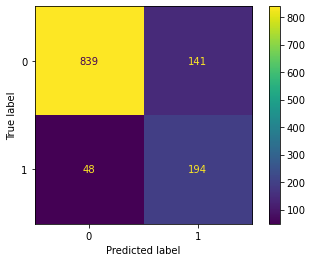

In [18]:
#Display confusion matrix using ConfusinMatrixDisplay
display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=brclf.classes_)
display.plot()

#Save Image
#plt.savefig("../Images/BalancedRandomForestClassifier_confusion_matrix.png")
plt.show()

In [19]:
# Print the imbalanced classification report
print("Balanced Random Forest Classifier")
print(classification_report_imbalanced(y_test, y_pred))


Balanced Random Forest Classifier
                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.86      0.80      0.90      0.83      0.69       980
          1       0.58      0.80      0.86      0.67      0.83      0.68       242

avg / total       0.87      0.85      0.81      0.85      0.83      0.69      1222



In [20]:
# List the features sorted in descending order by feature importance
by_features = sorted(zip(brclf.feature_importances_, X.columns), reverse=True)
for feature_rank in by_features:
    print(f"{feature_rank[1]}: ({feature_rank[0]})")

MonthlyIncome: (0.12519908117832063)
Age: (0.12045881839259515)
DurationOfPitch: (0.10710730273537461)
Passport: (0.08058131101696721)
NumberOfTrips: (0.06548687364303217)
PitchSatisfactionScore: (0.06148236790253882)
NumberOfFollowups: (0.05938325857699167)
ProductPitched_Basic: (0.04711747750348099)
PreferredPropertyStar: (0.04633386572826739)
CityTier: (0.040925329469335296)
NumberOfChildrenVisiting: (0.035466222296872386)
NumberOfPersonVisiting: (0.030903783881108184)
OwnCar: (0.0225754095890114)
ProductPitched_Deluxe: (0.02074546917543934)
MaritalStatus_Single: (0.019445323760101683)
TypeofContact_Company Invited: (0.018661976094905695)
MaritalStatus_Married: (0.018452439786815624)
Gender_Female: (0.01752249254178981)
Gender_Male: (0.01747064688996463)
TypeofContact_Self Enquiry: (0.016583228549533452)
ProductPitched_Standard: (0.013953577455747145)
ProductPitched_Super Deluxe: (0.009844628260561076)
ProductPitched_King: (0.004299115571245859)


### Easy Ensemble AdaBoost Classifier

In [21]:
# Train the EasyEnsembleClassifier
eec = EasyEnsembleClassifier(random_state=1, n_estimators = 100)
#fit/train
eec.fit(X_train, y_train) 

EasyEnsembleClassifier(n_estimators=100, random_state=1)

In [22]:
# Calculated the balanced accuracy score
#predict
y_pred =eec.predict(X_test)
#Balance Score
balanced_accuracy_score(y_test, y_pred)

0.723815145893068

In [23]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Act ProdTaken 0", "Act ProdTaken 1"], columns=["Pred ProdTaken 0", "Pred ProdTaken 1"])
cm_df

,Pred ProdTaken 0,Pred ProdTaken 1
Act ProdTaken 0,710,270
Act ProdTaken 1,67,175


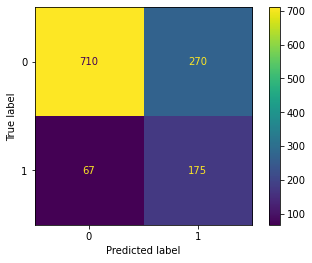

In [24]:
#Display confusion matrix using ConfusinMatrixDisplay
display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=eec.classes_)
display.plot()

#Save Image
#plt.savefig("../Images/EasyEnsembleClassifier_confusion_matrix.png")
plt.show()

In [25]:
# Print the imbalanced classification report
print("Easy Ensemble Classifier")
print(classification_report_imbalanced(y_test, y_pred))

Easy Ensemble Classifier
                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      0.72      0.72      0.81      0.72      0.52       980
          1       0.39      0.72      0.72      0.51      0.72      0.52       242

avg / total       0.81      0.72      0.72      0.75      0.72      0.52      1222

